In [1]:
print('Importation des librairies...')
import talib
from zigzag import *
import numpy as np
import pandas as pd
import pandas_datareader as web
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.style.use('seaborn')
import time
import datetime as dt
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,roc_curve,confusion_matrix,classification_report
print('Librairies imported')
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print('Librairies importées')


Importation des librairies...


Using TensorFlow backend.


Librairies imported
Librairies importées


In [2]:
# PARAMETRES TEMPORELS INITIAUX
start = pd.to_datetime('2015-03-03')
end = pd.to_datetime('2019-07-21')
ticker = 'AAPL'

In [3]:
# SCRAPING DES DONNES BRUTES
def scrap_data(ticker,start,end):
    df = web.DataReader(ticker,'yahoo',start,end)
    df = df.drop(['Close'],axis=1)
    df['Close'] = df['Adj Close']
    df = df.drop(['Adj Close'],axis = 1)
    df.tail()
    return(df)

In [4]:
def prepa_data(df):
    tmps1=time.time()
    print('Preparing data...')
    rsi = talib.RSI(df['Close'],timeperiod=2)
    upper, middle, lower =  talib.BBANDS(df['Close'], timeperiod=9, nbdevup=2, nbdevdn=2,matype=0)
    sma5 = talib.SMA(df['Close'],timeperiod=5)
    sma8 = talib.SMA(df['Close'],timeperiod=8)
    sma10 = talib.SMA(df['Close'],timeperiod=10)
    sma12 = talib.SMA(df['Close'],timeperiod=12)
    sma15 = talib.SMA(df['Close'],timeperiod=15)
    sma30 = talib.SMA(df['Close'],timeperiod=30)
    sma35 = talib.SMA(df['Close'],timeperiod=35)
    sma40 = talib.SMA(df['Close'],timeperiod=40)
    sma45 = talib.SMA(df['Close'],timeperiod=45)
    sma50 = talib.SMA(df['Close'],timeperiod=50)
    atr = talib.ATR(df['High'],df['Low'],df['Close'],timeperiod=10)
    delta5_8 = sma5 - sma8
    delta8_10 = sma8 - sma10
    delta10_12 = sma10 - sma12
    delta12_15 = sma12 - sma15
    delta15_30 = sma15 - sma30
    delta30_35 = sma30 - sma35
    delta35_40 = sma35 - sma40
    delta40_45 = sma40 - sma45
    delta45_50 = sma45 - sma50
    bbdelta = upper - middle
    price_bolup = df['Close'] - lower
    price_bolow = df['Close'] - upper
    Ema = talib.EMA(df['Close'],timeperiod=20)
    KC_High = Ema + 2*atr
    KC_Low = Ema - 2*atr
    aroondown, aroonup = talib.AROON(df['High'], df['Low'], timeperiod=9)
    aroon = aroonup - aroondown #(aroonup-aroondown)/abs((aroonup-aroondown))
    rsi5_list = []
    rsi95_list = []
    for i in range(0,df.shape[0]):
        try:
            rsi95_list.append(95 - rsi[i])
            rsi5_list.append(rsi[i] - 5)
        except:
            rsi95_list.append(0)
            rsi5_list.append(0)
    varop_spy = df['Open'] - df['Close']
    varhl_spy = df['High'] - df['Low']
    df['Varop_Spy'] = varop_spy
    df['Varhl_spy'] = varhl_spy
    df['RSI'] = rsi
    df['95 - RSI'] = np.array(rsi95_list)
    df['RSI - 5'] = np.array(rsi5_list)
    df['BBD_Delta_Up'] = bbdelta
    df['delta5_8'] = delta5_8
    df['delta8_10'] = delta8_10
    df['delta10_12'] = delta10_12
    df['delta12_15'] = delta12_15
    df['delta15_30'] = delta15_30
    df['delta30_35'] = delta30_35
    df['delta35_40'] = delta35_40
    df['delta40_45'] = delta40_45
    df['delta45_50'] = delta45_50
    df['KC_High'] = KC_High
    df['KC_Low'] = KC_Low
    df['upper'] = upper
    df['lower'] = lower
    df['var_bollup_kchigh'] = upper-KC_High
    df['var_bolllow_kclow'] = lower-KC_Low
    df['Aroon Up'] = aroonup
    df['Aroon Down'] = aroondown
    df['Delta Aroon'] = aroondown
    up = []
    down = []
    print(df.info())
    for i in range(0,df.shape[0]-5):
        if df.iloc[i+5,4] - df.iloc[i,4] > 0:
            up.append(1)
            down.append(0)
        elif df.iloc[i+5,4] - df.iloc[i,4] <0:
            up.append(0)
            down.append(1)
        else:
            up.append(0)
            down.append(0)
    up.append(0)
    down.append(0)
    up.append(0)
    down.append(0)
    up.append(0)
    down.append(0)
    up.append(0)
    down.append(0)
    up.append(0)
    down.append(0)
    df['target_up'] = up  # target_up # abs(np.array(valley))#target_up
    df['target_down'] = down # target_down # abs(np.array(peak))#target_down
    df = df.dropna()
    tmps2=round(time.time()-tmps1,2)
    print ("Data prepared in = %f" %tmps2,'seconds')
    return(df)

In [5]:
def deep_learning(df):
    tmps1=time.time()
    X = df.iloc[:,1:4]
    y_up = df.iloc[:,-2].values
    y_down = df.iloc[:,-1].values

    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)
    y_up = np.array(y_up).reshape(-1,1)
    y_down = np.array(y_down).reshape(-1,1)

    Xtrain = X[:bloc1,:]
    Xtest = X[bloc1:,:]
    ytrain_up = y_up[:bloc1,:]
    ytest_up = y_up[bloc1:,:]
    ytrain_down = y_down[:bloc1,:]
    ytest_down = y_down[bloc1:,:]

    seed = 770
    np.random.seed(seed)

    ytrain_up = ytrain_up.reshape(ytrain_up.shape[0],)
    ytrain_down = ytrain_down.reshape(ytrain_down.shape[0],)

    Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1])

    model_up = Sequential()
    # Add an input layer 
    model_up.add(Dense(23, activation='relu'))
    # Add one hidden layer 
    model_up.add(Dense(50, activation='relu'))
    # Add an output layer 
    model_up.add(Dense(1, activation='sigmoid'))

    model_down = Sequential()
    # Add an input layer 
    model_down.add(Dense(23, activation='relu'))
    # Add one hidden layer 
    model_down.add(Dense(50, activation='relu'))
    # Add an output layer 
    model_down.add(Dense(1, activation='sigmoid'))

    print('Processing move_up')
    model_up.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy','mse'])

    history_up = model_up.fit(Xtrain, ytrain_up,epochs=200, batch_size=32, verbose=0)
    print('\n')
    print('Processing move_down')
    model_down.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy','mse'])

    history_down = model_down.fit(Xtrain, ytrain_down,epochs=200, batch_size=32, verbose=0)
    print('\n')
    print('Computing done')
    print('\n')

    train_acc_up = model_up.evaluate(Xtrain, ytrain_up,verbose=1)
    train_acc_down = model_down.evaluate(Xtrain, ytrain_down,verbose=1)

    yhat_up = model_up.predict_classes(Xtest)
    yhat_down = model_down.predict_classes(Xtest)

    score_up = model_up.evaluate(Xtest, ytest_up,verbose=1)
    score_down = model_down.evaluate(Xtest, ytest_down,verbose=1)

    predict_up = model_up.predict(Xtest)
    predict_down = model_down.predict(Xtest)

    accuracy_up = accuracy_score(ytest_up, yhat_up)
    accuracy_down = accuracy_score(ytest_down, yhat_down)

    # La précision permet de mesurer la capacité du modèle à refuser résultats non-pertinents : vrais_positifs/(vrais_positifs+faux_positifs)
    precision_up = precision_score(ytest_up, yhat_up)  
    precision_down = precision_score(ytest_down, yhat_down) 


    # Recall : (vrai_positifs/(vrais_positifs+faux_négatifs))
    recall_up = recall_score(ytest_up, yhat_up) 
    recall_down = recall_score(ytest_down, yhat_down) 


    #roc_up=roc_auc_score(ytest_up,yhat_up)
    #roc_down=roc_auc_score(ytest_down,yhat_down)
    print('\n')
    print('RESULTATS UP\n')
    print('Accuracy: %.2f%%' % (accuracy_up * 100.0))
    print("Precision: %.2f%% " % (precision_up *100),' => Discrimnination des vrais positifs parmi les faux positifs')
    print("Recall: %.2f%% " % (recall_up * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
    #print("ROC: %.2f%% " % (roc_up *100))
    # get probabilities for positive class

    print(classification_report(ytest_up, yhat_up))
    conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
    conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
    conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
    print(confusion_matrix(ytest_up, yhat_up))

    print('\n')
    print('_______________________________________________________________________________________________________________________________________________________________\n')
    print('RESULTATS DOWN\n')
    print('Accuracy: %.2f%%' % (accuracy_down * 100.0))
    print("Precision: %.2f%% " % (precision_down *100),' => Discrimnination des vrais positifs parmi les faux positifs')
    print("Recall: %.2f%% " % (recall_down * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
    #print("ROC: %.2f%% " % (roc_down *100))
    # get probabilities for positive class

    print(classification_report(ytest_down, yhat_down))
    conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
    conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
    conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
    print(confusion_matrix(ytest_down, yhat_down))
    print('\n')

    resultats = pd.DataFrame()
    resultats['Date'] = df.iloc[bloc1:,0]
    resultats['Move Up'] = yhat_up
    resultats['Confiance up'] = (predict_up)*100
    resultats['Move Down'] = yhat_down
    resultats['Confiance Down'] = (predict_down)*100
    resultats['Actual'] = df['Close']

    tmps2=round(time.time()-tmps1,2)
    print ("Deep Learning executed in = %f" %tmps2,'seconds')
    #resultats.set_index('Date',inplace=True)
    #parse_dates=resultats['Date']
    return(resultats,precision_up,precision_down,model_up,model_down,scaler)

In [6]:
def learn(df):
    resultats,precision_up,precision_down,model_up,model_down,scaler = deep_learning(df)
    return(resultats,precision_up,precision_down,model_up,model_down,scaler)

In [7]:
global delta,bloc1,bloc2

tmps1=time.time()
print('Scraping data...')

df = scrap_data(ticker,start,end)
tmps2=round(time.time()-tmps1,2)
print ("executed in = %f" %tmps2,'seconds')

print('\n')
print('GOLEM begins Computing...')
print('\n')
delta = round(df.shape[0])
bloc1 = round(delta*0.80)
bloc2 = delta - bloc1
print("# of periods : ",delta)
print('On 80% - 20% slash : ')
print('Bloc 1 : ',bloc1,'\nBloc 2 :',bloc2,' periods ')
print('First period :',df.iloc[0,0])
print('Split period :',df.iloc[bloc1-1,0])
print('Last period :',df.iloc[df.shape[0]-1,0])
print('\n')

df = prepa_data(df)

resultats,precision_up,precision_down,model_up,model_down,scaler = learn(df)

Scraping data...
executed in = 1.570000 seconds


GOLEM begins Computing...


# of periods :  1104
On 80% - 20% slash : 
Bloc 1 :  883 
Bloc 2 : 221  periods 
First period : 129.52000427246094
Split period : 228.25999450683594
Last period : 206.5


Preparing data...
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1104 entries, 2015-03-03 to 2019-07-19
Data columns (total 29 columns):
High                 1104 non-null float64
Low                  1104 non-null float64
Open                 1104 non-null float64
Volume               1104 non-null float64
Close                1104 non-null float64
Varop_Spy            1104 non-null float64
Varhl_spy            1104 non-null float64
RSI                  1102 non-null float64
95 - RSI             1102 non-null float64
RSI - 5              1102 non-null float64
BBD_Delta_Up         1096 non-null float64
delta5_8             1097 non-null float64
delta8_10            1095 non-null float64
delta10_12           1093 non-null float64
delta1

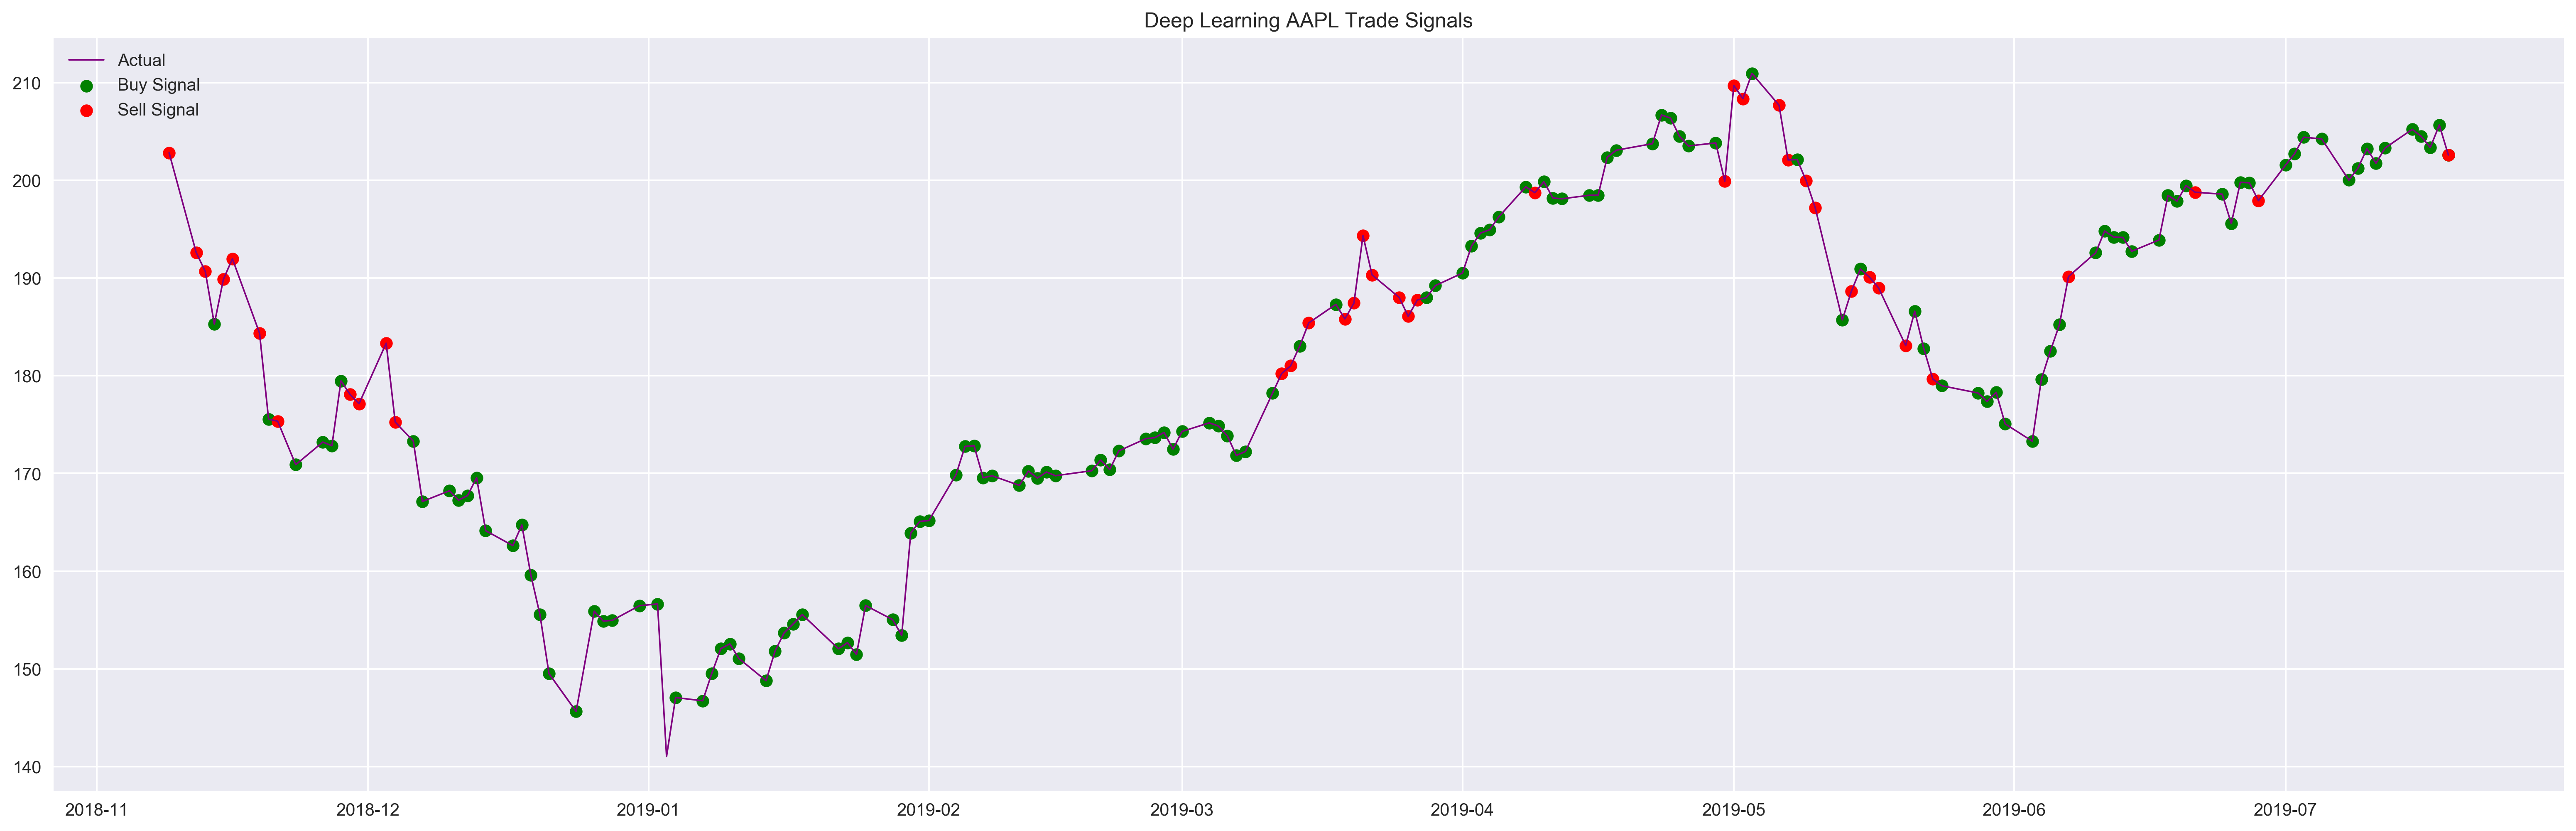

In [28]:
####################
#### TEST PLOT ####
###################

filtre_up = 50
filtre_down = 50


plt.figure(figsize=(26,8),dpi=300)
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.title('Deep Learning '+ticker+' Trade Signals')
plt.plot(resultats['Actual'],color='purple',lw=0.9)
if resultats.iloc[0]['Confiance Down'] > filtre_down:
    doob = -1
elif resultats.iloc[0]['Confiance up'] > filtre_up:
    doob = 1
else:
    doob = 0
green=[]
red=[]

for i in range(0,len(resultats)):
       
    
    if resultats.iloc[i]['Confiance Down'] > filtre_down:
        doob = -1
    
    elif resultats.iloc[i]['Confiance up'] > filtre_up:
        doob = 1
    
    else :
        doob = 0
    
    if doob == 1 and resultats.iloc[i]['Move Up'] == 1:
        plt.scatter(x=resultats.index[i],y=resultats.iloc[i,5],c='g',marker='o')
        #doob = -1
        green.append(1)
        red.append(0)
        
    elif doob == -1 and resultats.iloc[i]['Move Down'] == 1:
        plt.scatter(x=resultats.index[i],y=resultats.iloc[i,5],c='r',marker='o')
        #doob = 1
        green.append(0)
        red.append(1)
        
    else:
        green.append(0)
        red.append(0)
        #doob = 0
        

plt.scatter(x=resultats.index[i],y=resultats.iloc[i,5],c='g',marker='o',label='Buy Signal')
plt.scatter(x=resultats.index[i],y=resultats.iloc[i,5],c='r',marker='o',label='Sell Signal')
plt.legend()

In [29]:
resultats['Green'] = green
resultats['Red'] = red
resultats['Actual'] = df['Close'][bloc1:]
resultats.head()

,Date,Move Up,Confiance up,Move Down,Confiance Down,Actual,Green,Red
Date,,,,,,,,
2018-11-09,206.009995,0,46.589371,1,57.105881,202.815765,0,1
2018-11-12,199.850006,0,48.957294,1,54.599457,192.599106,0,1
2018-11-13,197.179993,1,50.402920,1,53.598499,190.674789,0,1
2018-11-14,194.479996,1,52.637451,0,48.120750,185.288742,1,0
2018-11-15,191.970001,1,51.200359,1,52.628090,189.861435,0,1


In [30]:
a = -1
pos_long = 0
pos_short = 0
pactol = 100000
price_buy = 0
price_sell = 0
x = 0
winners = []
loosers = []
nb_win = 0
nb_los = 0
mini_pnl = 0
pos_duration = []
average_duration = resultats.iloc[0,0] - resultats.iloc[0,0]



for i in range(0,len(resultats)):
    a+=1
    if pos_long == 0 and pos_short == 0 and resultats.iloc[a,-2] == 1 :
        pos_long = 1
        x = 100000/resultats.iloc[a,5]
        #pactol = pactol - (x * resultats.iloc[a,5])
        price_buy = resultats.iloc[a,5]
        time_enter = resultats.iloc[a,0]
        print('\n Le ',str(resultats.iloc[a,0]),', achat de ',x,' actions à',resultats.iloc[a,5],'$')
        print('Nouveau pactol : ',pactol)
    
    elif pos_long == 1 and resultats.iloc[a,-1] == 1 :
        old_pactol = pactol
        #pactol = pactol + (x * resultats.iloc[a,5])
        
        price_sell = resultats.iloc[a,5]
        mini_pnl = x*(price_sell-price_buy)
        pactol = pactol + mini_pnl
        print('\n Le ',str(resultats.iloc[a,0]),', vente pour close de ',x,' actions à',resultats.iloc[a,5],'$')
        print('Nouveau pactol : ',pactol)
        print('pnl:', mini_pnl)
        print('prixe de vente',price_sell)
        print('prix d achat',price_buy)
        #mini_pnl = pactol - old_pactol - 100000
        
        pos_duration.append(resultats.iloc[a,0] - time_enter)
        price_buy=0
        if mini_pnl > 0:
            winners.append(mini_pnl)
            mini_pnl = 0
            nb_win +=1
        else :
            loosers.append(mini_pnl)
            mini_pnl = 0
            nb_los +=1
        pos_short = 1
        x = 100000/resultats.iloc[a,5]
        #pactol = pactol - (x * resultats.iloc[a,5])
        time_enter = resultats.iloc[a,0]
        print('\n Le ',str(resultats.iloc[a,0]),', vente de ',x,' actions à',resultats.iloc[a,5],'$')
        print('Nouveau pactol : ',pactol)
        pos_long = 0
        #x = 0
        
    elif pos_short == 0 and pos_long == 0 and resultats.iloc[a,-1]:
        pos_short = 1
        x = 100000/resultats.iloc[a,5]
        price_sell = resultats.iloc[a,5]
        #pactol = pactol - (x * resultats.iloc[a,5])
        time_enter = resultats.iloc[a,0]
        print('\n Le ',str(resultats.iloc[a,0]),', vente de ',x,' actions à',resultats.iloc[a,5],'$')
        print('Nouveau pactol : ',pactol)
    
    elif pos_short == 1 and resultats.iloc[a,-1] == 1 :
        old_pactol = pactol
        #pactol = pactol + (x * resultats.iloc[a,5])
     
        price_buy=resultats.iloc[a,5]
        mini_pnl = x*(price_sell-price_buy)
        pactol = pactol + mini_pnl
        print('\n Le ',str(resultats.iloc[a,0]),', achat pour close de ',x,' actions à',resultats.iloc[a,5],'$')
        print('Nouveau pactol : ',pactol)
        
        print('prix de vente',price_sell)
        print('prix d achat',price_buy)
        #mini_pnl = pactol - old_pactol - 100000
        
        print('pnl:', mini_pnl)
        pos_duration.append(resultats.iloc[a,0] - time_enter)
        if mini_pnl > 0:
            winners.append(mini_pnl)
            mini_pnl = 0
            nb_win +=1
        else :
            loosers.append(mini_pnl)
            mini_pnl = 0
            nb_los +=1
        pos_long = 1
        x = 100000/resultats.iloc[a,5]
        #pactol = pactol - (x * resultats.iloc[a,5])
        time_enter = resultats.iloc[a,0]
        print('\n Le ',str(resultats.iloc[a,0]),', achat de ',x,' actions à',resultats.iloc[a,5],'$')
        print('Nouveau pactol : ',pactol)
        pos_short = 0
        #x = 0

        
if pos_long == 1:
    print('Cutting non resolved position')
    x = round(100000/resultats.iloc[a,5])
    #pactol = pactol + (x * resultats.iloc[a,5])
    #mini_pnl = pactol - old_pactol - 100000
    price_sell = resultats.iloc[a,5]
    mini_pnl = x*(price_sell-price_buy)
    pactol = pactol + mini_pnl
    print('pnl',mini_pnl)
    if mini_pnl > 0:
        winners.append(mini_pnl)
        mini_pnl = 0
        nb_win +=1
    else :
        loosers.append(mini_pnl)
        mini_pnl = 0
        nb_los +=1
    x = 0

if pos_short == 1:
    print('Cutting non resolved position')
    x = round(100000/resultats.iloc[a,5])
    #pactol = pactol + (x * resultats.iloc[a,5])
    #mini_pnl = pactol - old_pactol - 100000
    price_buy=resultats.iloc[a,5]
    mini_pnl = x*(price_sell-price_buy)
    pactol = pactol + mini_pnl
    print('pnl',mini_pnl)
    
    if mini_pnl > 0:
        winners.append(mini_pnl)
        mini_pnl = 0
        nb_win +=1
    else :
        loosers.append(mini_pnl)
        mini_pnl = 0
        nb_los +=1
    x = 0    



pnl = round(pactol - 100000,2)
print('\n Begining of BackTest :',resultats.iloc[0,0])
print('Instrument :',ticker)
print('Face value per trade : $100,000')
print('End of BackTest :',resultats.iloc[-1,0])
duration = resultats.iloc[-1,0] - resultats.iloc[0,0]
print("BackTest's period :",duration)
print( 'pnl :',pnl,'$')
print('Total winners :',round(sum(winners),2),'$')
print('Total loosers :',round(sum(loosers),2),'$')
print('Number of winners :',nb_win)
print('Number of loosers :',nb_los)
try:
    print('% winners :', round((nb_win/(nb_win+nb_los) * 100),2),'%')
    print('Average winners :',(round(sum(winners)/(nb_win))))
except:
    print('% winners : null')
try:
    print('Average losers :',(round(sum(loosers)/(nb_los))))
except:
    print('Average losers : Inf')
try:
    for t in range(0,len(pos_duration)):
        average_duration = average_duration + pos_duration[t]
    average_duration = average_duration/(nb_los+nb_win)
    print('Average Duration :', average_duration)
except:
    print('No Average Duration available')
try:
    print('Profit Factor : ',abs(round((sum(winners)/sum(loosers)),2)))
except:
    print('Profit Factor : null')


 Le  206.00999450683594 , vente de  493.05831729705096  actions à 202.81576538085938 $
Nouveau pactol :  100000

 Le  199.85000610351562 , achat pour close de  493.05831729705096  actions à 192.59910583496094 $
Nouveau pactol :  105037.40896409753
prix de vente 202.81576538085938
prix d achat 192.59910583496094
pnl: 5037.408964097536

 Le  199.85000610351562 , achat de  519.2132100846328  actions à 192.59910583496094 $
Nouveau pactol :  105037.40896409753

 Le  197.17999267578125 , vente pour close de  519.2132100846328  actions à 190.67478942871094 $
Nouveau pactol :  104038.27846558994
pnl: -999.1304985075868
prixe de vente 190.67478942871094
prix d achat 192.59910583496094

 Le  197.17999267578125 , vente de  524.4531817741316  actions à 190.67478942871094 $
Nouveau pactol :  104038.27846558994

 Le  191.97000122070312 , achat pour close de  524.4531817741316  actions à 189.86143493652344 $
Nouveau pactol :  104464.84481692796
prix de vente 190.67478942871094
prix d achat 189.86143


 Le  206.00999450683594 , vente de  493.05831729705096  actions à 202.81576538085938 $
Nouveau pactol :  100000

 Le  181.47000122070312 , achat pour close de  493.05831729705096  actions à 175.54815673828125 $
Nouveau pactol :  113444.5212340241
prixe de vente 202.81576538085938
prix d achat 175.54815673828125
pnl: 13444.521234024094

 Le  181.47000122070312 , achat de  569.6442609140385  actions à 175.54815673828125 $
Nouveau pactol :  113444.5212340241

 Le  197.69000244140625 , vente pour close de  569.6442609140385  actions à 190.3170928955078 $
Nouveau pactol :  121857.56095579405
pnl: 8413.039721769945
prixe de vente 190.3170928955078
prix d achat 175.54815673828125

 Le  197.69000244140625 , vente de  525.4388792860778  actions à 190.3170928955078 $
Nouveau pactol :  121857.56095579405

 Le  189.55999755859375 , achat pour close de  525.4388792860778  actions à 187.99603271484375 $
Nouveau pactol :  123077.13621587772
prixe de vente 190.3170928955078
prix d achat 187.996032714

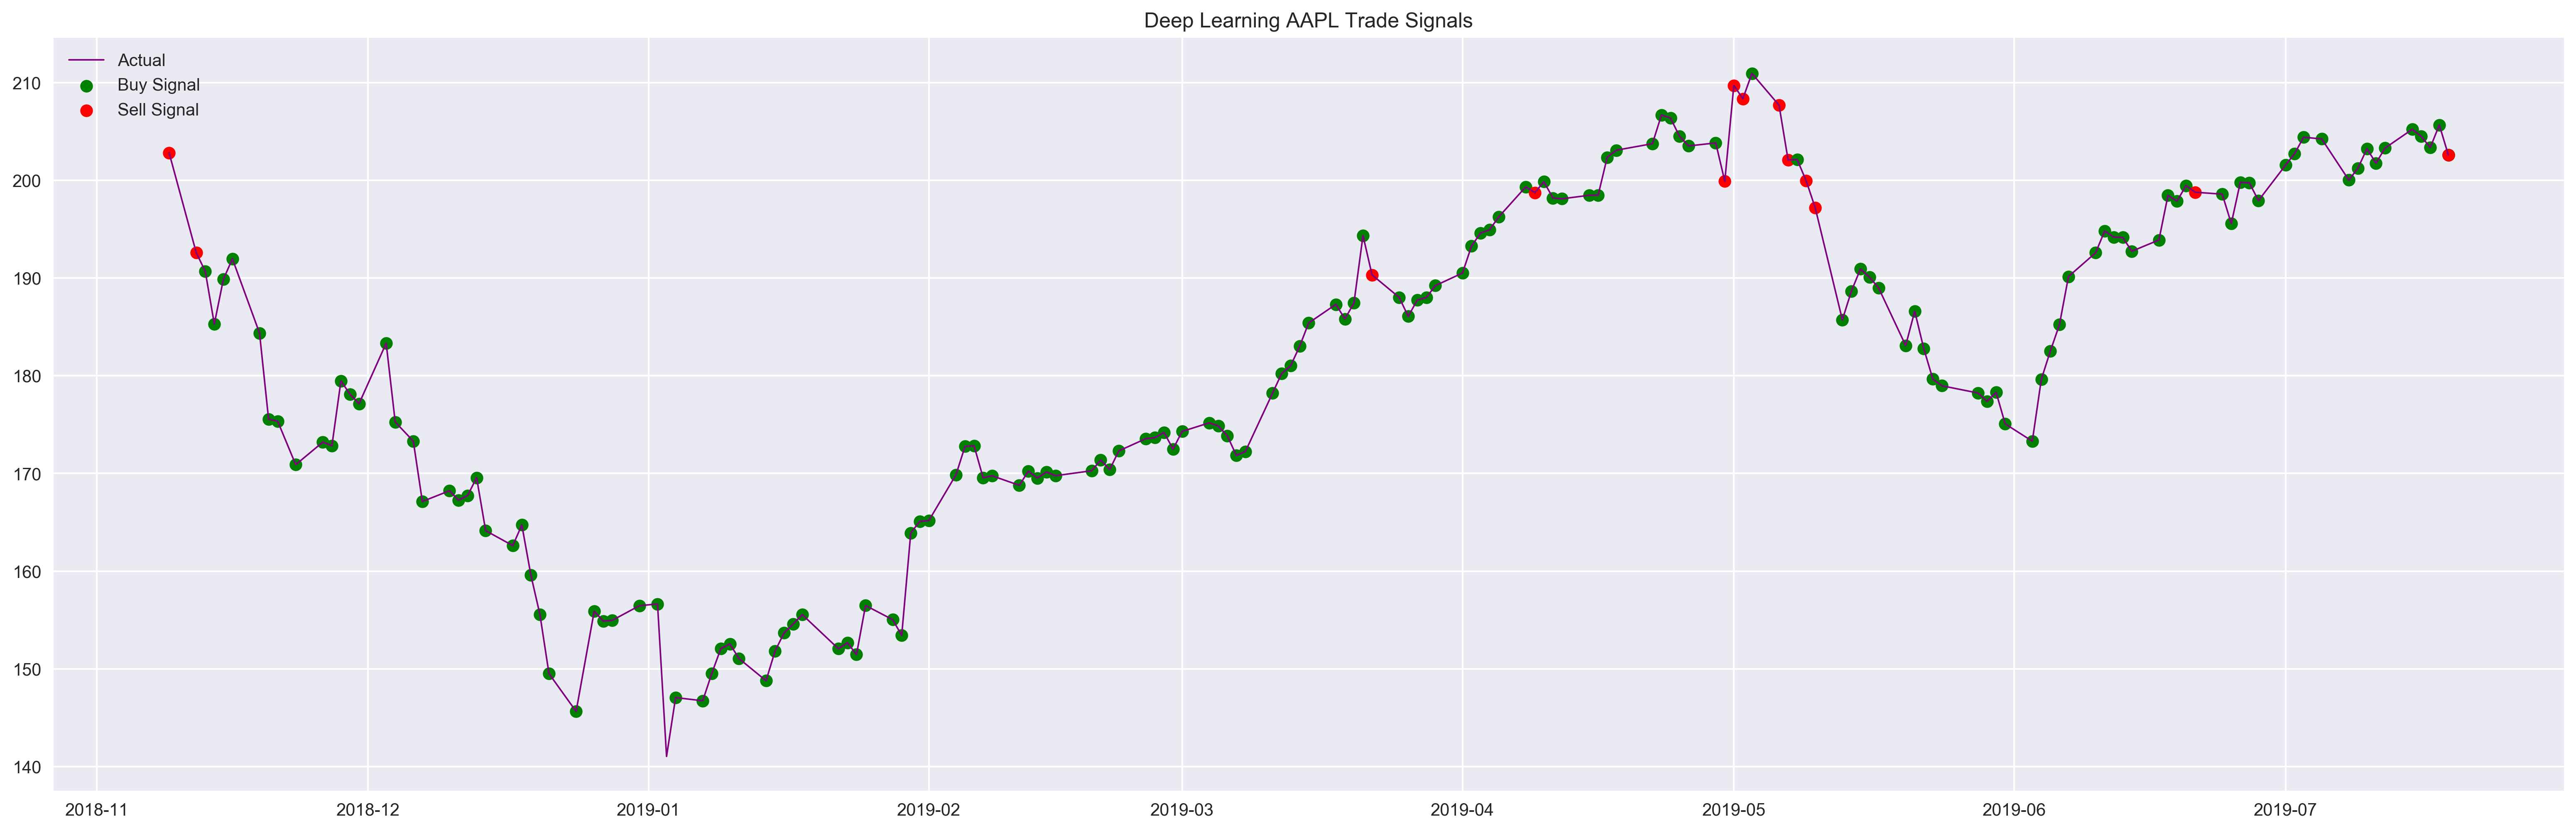

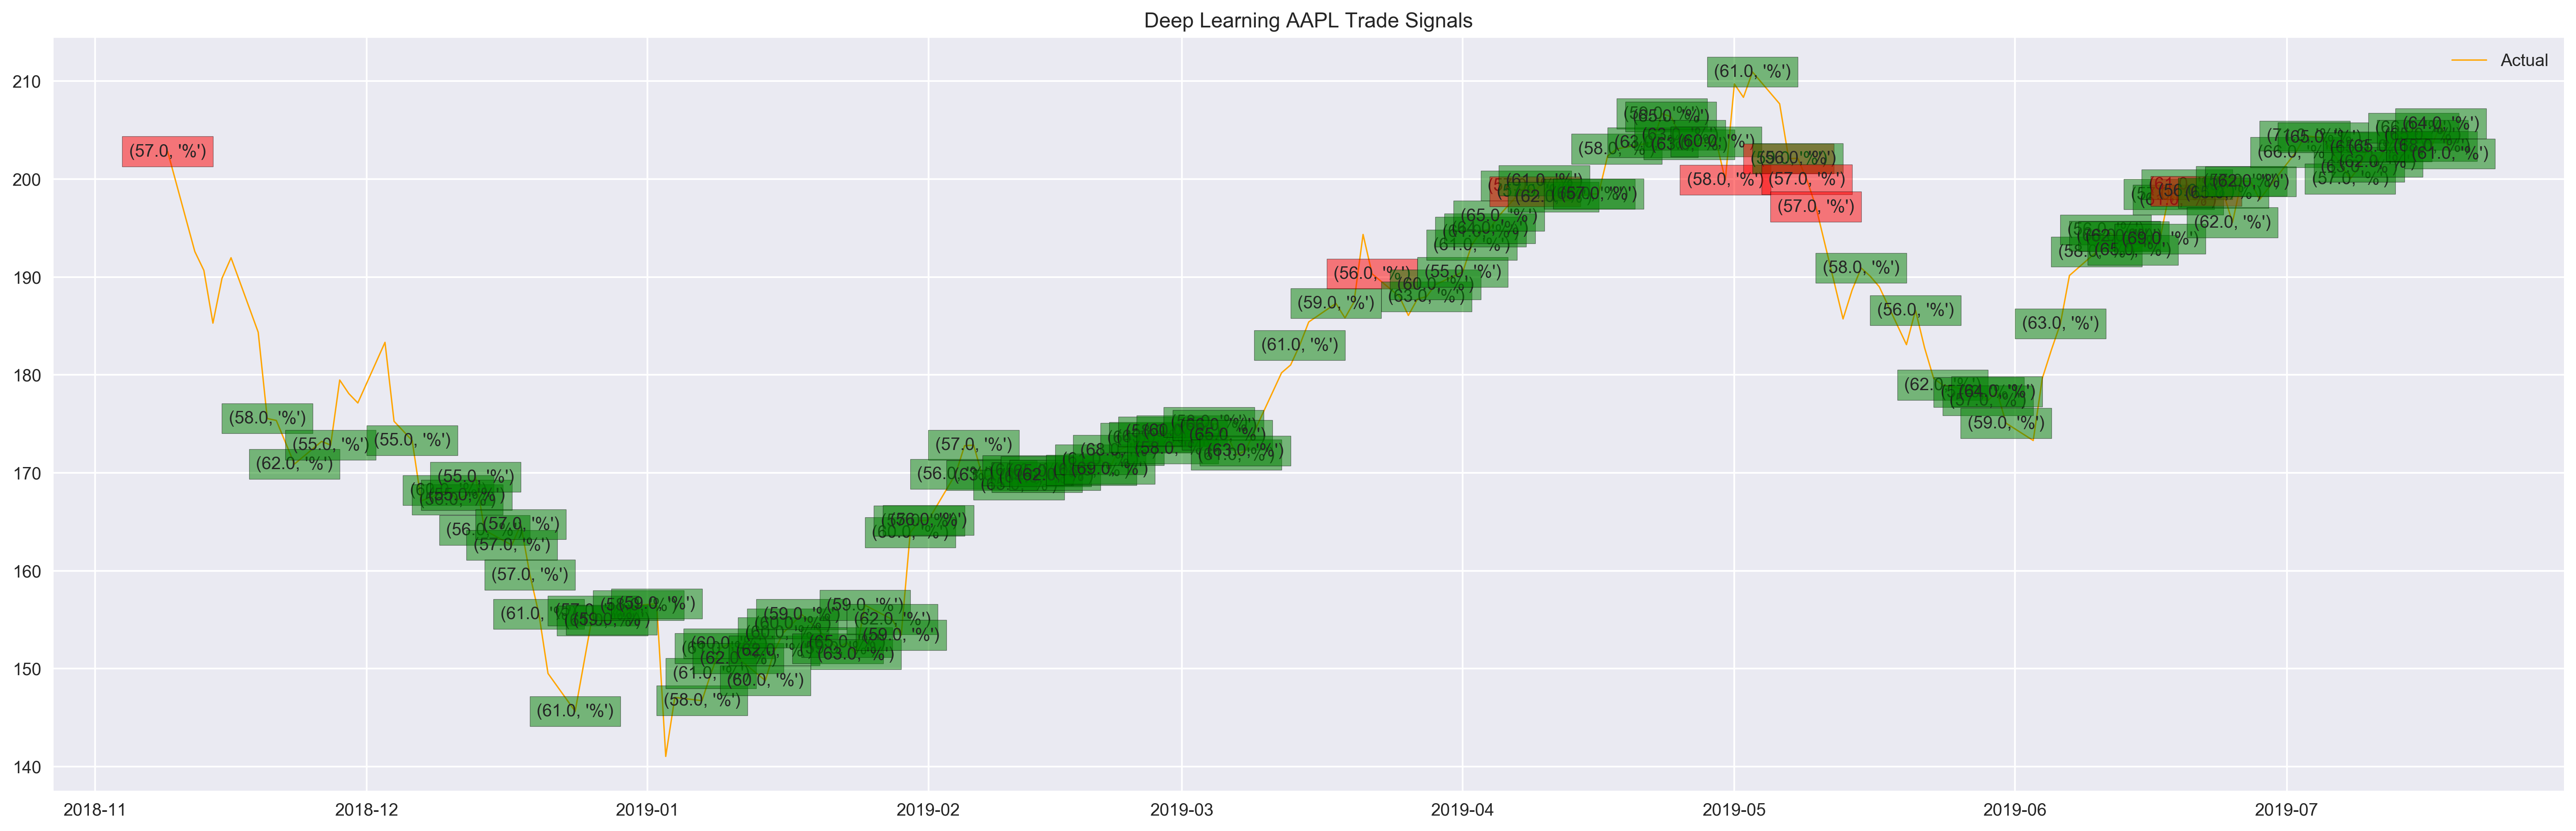

In [8]:
####################
#### TEST PLOT ####
###################


plt.figure(figsize=(26,8),dpi=300)
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.title('Deep Learning '+ticker+' Trade Signals')
plt.plot(resultats['Actual'],color='purple',lw=0.9)
a = -1
for i in range(0,len(resultats)):
    a+=1
    if resultats.iloc[a,1] == 1:
        plt.scatter(x=resultats.index[i],y=resultats.iloc[i,5],c='g',marker='o')
    elif resultats.iloc[a,3] == 1:
        plt.scatter(x=resultats.index[i],y=resultats.iloc[i,5],c='r',marker='o')

plt.scatter(x=resultats.index[i],y=resultats.iloc[i,5],c='g',marker='o',label='Buy Signal')
plt.scatter(x=resultats.index[i],y=resultats.iloc[i,5],c='r',marker='o',label='Sell Signal')
plt.legend()

plt.figure(figsize=(26,8),dpi=300)
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.title('Deep Learning '+ticker+' Trade Signals')
plt.plot(resultats['Actual'],color='orange',lw=0.8)
a = -1
proba = 55
for i in range(0,len(resultats)):
    a+=1
    if resultats.iloc[a,1] == 1 and resultats.iloc[i,2] >= proba:
        plt.text(x=resultats.index[i],y=resultats.iloc[i,5],s=(round(resultats.iloc[i,2]),'%'), horizontalalignment = 'center', verticalalignment = 'center',
                bbox=dict(facecolor='green', alpha=0.5))
    elif resultats.iloc[a,3] == 1and resultats.iloc[i,4] >= proba:
        plt.text(x=resultats.index[i],y=resultats.iloc[i,5],s=(round(resultats.iloc[i,4]),'%'), horizontalalignment = 'center', verticalalignment = 'center',
                bbox=dict(facecolor='red', alpha=0.5))
plt.legend()


a = -1
pos_long = 0
pos_short = 0
pactol = 100000
price_buy = 0
price_sell = 0
x = 0
winners = []
loosers = []
nb_win = 0
nb_los = 0
mini_pnl = 0
pos_duration = []
average_duration = resultats.iloc[0,0] - resultats.iloc[0,0]
proba = 55


for i in range(0,len(resultats)):
    a+=1
    if pos_long == 0 and pos_short == 0 and resultats.iloc[a,1] == 1 and resultats.iloc[a,2] > proba:
        pos_long = 1
        x = 100000/resultats.iloc[a,5]
        #pactol = pactol - (x * resultats.iloc[a,5])
        price_buy = resultats.iloc[a,5]
        time_enter = resultats.iloc[a,0]
        print('\n Le ',str(resultats.iloc[a,0]),', achat de ',x,' actions à',resultats.iloc[a,5],'$')
        print('Nouveau pactol : ',pactol)
    
    elif pos_long == 1 and resultats.iloc[a,3] == 1 and resultats.iloc[a,4] > proba:
        old_pactol = pactol
        #pactol = pactol + (x * resultats.iloc[a,5])
        
        price_sell = resultats.iloc[a,5]
        mini_pnl = x*(price_sell-price_buy)
        pactol = pactol + mini_pnl
        print('\n Le ',str(resultats.iloc[a,0]),', vente pour close de ',x,' actions à',resultats.iloc[a,5],'$')
        print('Nouveau pactol : ',pactol)
        print('pnl:', mini_pnl)
        print('prixe de vente',price_sell)
        print('prix d achat',price_buy)
        #mini_pnl = pactol - old_pactol - 100000
        
        pos_duration.append(resultats.iloc[a,0] - time_enter)
        price_buy=0
        if mini_pnl > 0:
            winners.append(mini_pnl)
            mini_pnl = 0
            nb_win +=1
        else :
            loosers.append(mini_pnl)
            mini_pnl = 0
            nb_los +=1
        pos_short = 1
        x = 100000/resultats.iloc[a,5]
        #pactol = pactol - (x * resultats.iloc[a,5])
        time_enter = resultats.iloc[a,0]
        print('\n Le ',str(resultats.iloc[a,0]),', vente de ',x,' actions à',resultats.iloc[a,5],'$')
        print('Nouveau pactol : ',pactol)
        pos_long = 0
        #x = 0
        
    elif pos_short == 0 and pos_long == 0 and resultats.iloc[a,3] == 1 and resultats.iloc[a,4] > proba:
        pos_short = 1
        x = 100000/resultats.iloc[a,5]
        price_sell = resultats.iloc[a,5]
        #pactol = pactol - (x * resultats.iloc[a,5])
        time_enter = resultats.iloc[a,0]
        print('\n Le ',str(resultats.iloc[a,0]),', vente de ',x,' actions à',resultats.iloc[a,5],'$')
        print('Nouveau pactol : ',pactol)
    
    elif pos_short == 1 and resultats.iloc[a,1] == 1 and resultats.iloc[a,2] > proba:
        old_pactol = pactol
        #pactol = pactol + (x * resultats.iloc[a,5])
     
        price_buy=resultats.iloc[a,5]
        mini_pnl = x*(price_sell-price_buy)
        pactol = pactol + mini_pnl
        print('\n Le ',str(resultats.iloc[a,0]),', achat pour close de ',x,' actions à',resultats.iloc[a,5],'$')
        print('Nouveau pactol : ',pactol)
        
        print('prixe de vente',price_sell)
        print('prix d achat',price_buy)
        #mini_pnl = pactol - old_pactol - 100000
        
        print('pnl:', mini_pnl)
        pos_duration.append(resultats.iloc[a,0] - time_enter)
        if mini_pnl > 0:
            winners.append(mini_pnl)
            mini_pnl = 0
            nb_win +=1
        else :
            loosers.append(mini_pnl)
            mini_pnl = 0
            nb_los +=1
        pos_long = 1
        x = 100000/resultats.iloc[a,5]
        #pactol = pactol - (x * resultats.iloc[a,5])
        time_enter = resultats.iloc[a,0]
        print('\n Le ',str(resultats.iloc[a,0]),', achat de ',x,' actions à',resultats.iloc[a,5],'$')
        print('Nouveau pactol : ',pactol)
        pos_short = 0
        #x = 0

        
if pos_long == 1:
    print('Cutting non resolved position')
    x = round(100000/resultats.iloc[a,5])
    #pactol = pactol + (x * resultats.iloc[a,5])
    #mini_pnl = pactol - old_pactol - 100000
    price_sell = resultats.iloc[a,5]
    mini_pnl = x*(price_sell-price_buy)
    pactol = pactol + mini_pnl
    print('pnl',mini_pnl)
    if mini_pnl > 0:
        winners.append(mini_pnl)
        mini_pnl = 0
        nb_win +=1
    else :
        loosers.append(mini_pnl)
        mini_pnl = 0
        nb_los +=1
    x = 0

if pos_short == 1:
    print('Cutting non resolved position')
    x = round(100000/resultats.iloc[a,5])
    #pactol = pactol + (x * resultats.iloc[a,5])
    #mini_pnl = pactol - old_pactol - 100000
    price_buy=resultats.iloc[a,5]
    mini_pnl = x*(price_sell-price_buy)
    pactol = pactol + mini_pnl
    print('pnl',mini_pnl)
    
    if mini_pnl > 0:
        winners.append(mini_pnl)
        mini_pnl = 0
        nb_win +=1
    else :
        loosers.append(mini_pnl)
        mini_pnl = 0
        nb_los +=1
    x = 0    


for t in range(0,len(pos_duration)):
    average_duration = average_duration + pos_duration[t]
average_duration = average_duration/(nb_los+nb_win)
               

pnl = round(pactol - 100000,2)
print('\n Begining of BackTest :',resultats.iloc[0,0])
print('Instrument :',ticker)
print('Face value per trade : $100,000')
print('End of BackTest :',resultats.iloc[-1,0])
duration = resultats.iloc[-1,0] - resultats.iloc[0,0]
print("BackTest's period :",duration)
print( 'pnl :',pnl,'$')
print('Total winners :',round(sum(winners),2),'$')
print('Total loosers :',round(sum(loosers),2),'$')
print('Number of winners :',nb_win)
print('Number of loosers :',nb_los)
try:
    print('% winners :', round((nb_win/(nb_win+nb_los) * 100),2),'%')
    print('Average winners :',(round(sum(winners)/(nb_win))))
except:
    print('% winners : null')
try:
    print('Average losers :',(round(sum(loosers)/(nb_los))))
except:
    print('Average losers : Inf')
print('Average Duration :', average_duration)
try:
    print('Profit Factor : ',abs(round((sum(winners)/sum(loosers)),2)))
except:
    print('Profit Factor : null')